# HW2B: Neural Machine Translation

In this project, you will build a neural machine translation system using modern techniques for sequence-to-sequence modeling. You will first implement a baseline encoder-decoder architecture, then improve upon the baseline by adding an attention mechanism. The end result will be a fully functional translation system capable of translating simple German sentences into English.

## Setup

First we install and import the required dependencies. These include:
* `torch` for modeling and training
* `torchtext` for data collection
* `sentencepiece` for subword tokenization
* `sacrebleu` for BLEU score evaluation

In [1]:
# Some of the functions below require an older version of torchtext than the default one Kaggle gives you.
# IMPORTANT: Make sure that Internet is turned on!!! (Notebook options in the bar on the right)
# IMPORTANT: If you're not already using Kaggle, we STRONGLY recommend you switch to Kaggle for hw1b in particular,
# because copying our notebook will pin you to a Python version that lets you install the right version of torchtext.
# On Colab you will have to downgrade your Python to e.g., 3.7 to do the below pip install, which is a pain to do.
# !pip install torchtext==0.8.1
# exit()

In [2]:
# %%capture
# !pip install --upgrade sacrebleu sentencepiece
# Standard library imports

import json
import math
import random
import pdb

# Third party imports
import matplotlib.pyplot as plt
import numpy as np
import sacrebleu
import sentencepiece
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchtext
import tqdm.notebook

Before proceeding, let's verify that we're connected to a GPU runtime and that `torch` can detect the GPU.
We'll define a variable `device` here to use throughout the code so that we can easily change to run on CPU for debugging.

In [3]:
assert torch.cuda.is_available()
device = torch.device("cuda")
print("Using device:", device)

Using device: cuda


## Data

The data for this assignment comes from the [Multi30K dataset](https://arxiv.org/abs/1605.00459), which contains English and German captions for images from Flickr. We can download and unpack it using `torchtext`. We use the Multi30K dataset because it is simpler than standard translation benchmark datasets and allows for models to be trained and evaluated in a matter of minutes rather than days.

We will be translating from German to English in this assignment, but the same techniques apply equally well to any language pair.



In [4]:
import torchtext
from torchtext.datasets import Multi30k

Multi30k.urls = [
    "https://raw.githubusercontent.com/neychev/small_DL_repo/master/datasets/Multi30k/training.tar.gz",
    "https://raw.githubusercontent.com/neychev/small_DL_repo/master/datasets/Multi30k/validation.tar.gz",
    "https://raw.githubusercontent.com/neychev/small_DL_repo/master/datasets/Multi30k/mmt16_task1_test.tar.gz"
]

extensions = [".de", ".en"]
source_field = torchtext.data.Field(tokenize=lambda x: x)
target_field = torchtext.data.Field(tokenize=lambda x: x)
training_data, validation_data, test_data = torchtext.datasets.Multi30k.splits(
    extensions, [source_field, target_field], root="", test="test")

/opt/conda/envs/py37/lib/python3.7/site-packages/torchtext/data/field.py:150: UserWarning: Field class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)
/opt/conda/envs/py37/lib/python3.7/site-packages/torchtext/data/example.py:78: UserWarning: Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.', UserWarning)


Now that we have the data, let's see how large each split is and look at a few examples.


In [5]:
print("Number of training examples:", len(training_data))
print("Number of validation examples:", len(validation_data))
print("Number of test examples:", len(test_data))
print()

for example in training_data[:10]:
  print(example.src)
  print(example.trg)
  print()

Number of training examples: 29000
Number of validation examples: 1014
Number of test examples: 1000

Zwei junge weiße Männer sind im Freien in der Nähe vieler Büsche.
Two young, White males are outside near many bushes.

Mehrere Männer mit Schutzhelmen bedienen ein Antriebsradsystem.
Several men in hard hats are operating a giant pulley system.

Ein kleines Mädchen klettert in ein Spielhaus aus Holz.
A little girl climbing into a wooden playhouse.

Ein Mann in einem blauen Hemd steht auf einer Leiter und putzt ein Fenster.
A man in a blue shirt is standing on a ladder cleaning a window.

Zwei Männer stehen am Herd und bereiten Essen zu.
Two men are at the stove preparing food.

Ein Mann in grün hält eine Gitarre, während der andere Mann sein Hemd ansieht.
A man in green holds a guitar while the other man observes his shirt.

Ein Mann lächelt einen ausgestopften Löwen an.
A man is smiling at a stuffed lion

Ein schickes Mädchen spricht mit dem Handy während sie langsam die Straße entla

## Vocabulary

We can use `sentencepiece` to create a joint German-English subword vocabulary from the training corpus. Because the number of training examples is small, we choose a smaller vocabulary size than would be used for large-scale NMT.

In [6]:
args = {
    "pad_id": 0,
    "bos_id": 1,
    "eos_id": 2,
    "unk_id": 3,
    "input": "multi30k/train.de,multi30k/train.en",
    "vocab_size": 8000,
    "model_prefix": "multi30k",
}
combined_args = " ".join(
    "--{}={}".format(key, value) for key, value in args.items())
sentencepiece.SentencePieceTrainer.Train(combined_args)

sentencepiece_trainer.cc(177) LOG(INFO) Running command: --pad_id=0 --bos_id=1 --eos_id=2 --unk_id=3 --input=multi30k/train.de,multi30k/train.en --vocab_size=8000 --model_prefix=multi30k
sentencepiece_trainer.cc(77) LOG(INFO) Starts training with : 
trainer_spec {
  input: multi30k/train.de
  input: multi30k/train.en
  input_format: 
  model_prefix: multi30k
  model_type: UNIGRAM
  vocab_size: 8000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  pretokenization_delimiter: 
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  hard_vocab_limit: 1
  use_all_

This creates two files: `multi30k.model` and `multi30k.vocab`. The first is a binary file containing the relevant data for the vocabulary. The second is a human-readable listing of each subword and its associated score.

We can preview the contents of the vocabulary by looking at the first few rows from the human-readable file.

In [7]:
!head -n 30 multi30k.vocab

<pad>	0
<s>	0
</s>	0
<unk>	0
.	-2.72718
▁a	-3.21357
▁in	-3.43973
m	-3.78503
▁eine	-3.82141
▁A	-3.86856
s	-4.06457
▁Ein	-4.11399
,	-4.20405
▁the	-4.35217
▁und	-4.5704
▁mit	-4.57911
▁auf	-4.58144
▁on	-4.65674
n	-4.67038
▁Mann	-4.70521
▁is	-4.73988
▁man	-4.75331
▁and	-4.76404
▁	-4.76512
ing	-4.8072
▁of	-4.83344
▁einer	-4.86421
▁with	-4.93426
▁Eine	-4.98902
▁ein	-5.126


As we can see, the vocabulary consists of four special tokens (`<pad>` for padding, `<s>` for beginning of sentence (BOS), `</s>` for end of sentence (EOS), `<unk>` for unknown) and a mixture of German and English words and subwords. In order to ensure reversability, word boundaries are encoded with a special unicode character "▁" (U+2581).

To use the vocabulary, we first need to load it from the binary file produced above.

In [8]:
vocab = sentencepiece.SentencePieceProcessor()
vocab.Load("multi30k.model")

True

The vocabulary object includes a number of methods for working with full sequences or individual pieces. We explore the most relevant ones below. A complete interface can be found on [GitHub](https://github.com/google/sentencepiece/tree/master/python#usage) for reference.

In [9]:
print("Vocabulary size:", vocab.GetPieceSize())
print()

for example in training_data[:1]:
  sentence = example.trg
  pieces = vocab.EncodeAsPieces(sentence)
  indices = vocab.EncodeAsIds(sentence)
  print(sentence)
  print(pieces)
  print(vocab.DecodePieces(pieces))
  print(indices)
  print(vocab.DecodeIds(indices))
  print()

piece = vocab.EncodeAsPieces("the")[0]
index = vocab.PieceToId(piece)
print(piece)
print(index)
print(vocab.IdToPiece(index))

Vocabulary size: 8000

Two young, White males are outside near many bushes.
['▁Two', '▁young', ',', '▁White', '▁males', '▁are', '▁outside', '▁near', '▁many', '▁bushes', '.']
Two young, White males are outside near many bushes.
[42, 54, 12, 2889, 2225, 36, 127, 173, 815, 3513, 4]
Two young, White males are outside near many bushes.

▁the
13
▁the


We define some constants here for the first three special tokens that you may find useful in the following sections.

In [10]:
pad_id = vocab.PieceToId("<pad>")
bos_id = vocab.PieceToId("<s>")
eos_id = vocab.PieceToId("</s>")

Note that these tokens will be stripped from the output when converting from word pieces to text. This may be helpful when implementing greedy search and beam search.

In [11]:
sentence = training_data[0].trg
indices = vocab.EncodeAsIds(sentence)
indices_augmented = [bos_id] + indices + [eos_id, pad_id, pad_id, pad_id]
print(vocab.DecodeIds(indices))
print(vocab.DecodeIds(indices_augmented))
print(vocab.DecodeIds(indices) == vocab.DecodeIds(indices_augmented))

Two young, White males are outside near many bushes.
Two young, White males are outside near many bushes.
True


## Baseline sequence-to-sequence model

With our data and vocabulary loaded, we're now ready to build a baseline sequence-to-sequence model.  Later on we'll add an attention mechanism to the model.

Let's begin by defining a batch iterator for the training data. Given a dataset and a batch size, it will iterate over the dataset and yield pairs of tensors containing the subword indices for the source and target sentences in the batch, respectively.  Fill in `make_batch` below.

In [12]:
def make_batch(sentences):
  """Convert a list of sentences into a batch of subword indices.

  Args:
    sentences: A list of sentences, each of which is a string.

  Returns:
    A LongTensor of size (max_sequence_length, batch_size) containing the
    subword indices for the sentences, where max_sequence_length is the length
    of the longest sentence as encoded by the subword vocabulary and batch_size
    is the number of sentences in the batch. A beginning-of-sentence token
    should be included before each sequence, and an end-of-sentence token should
    be included after each sequence. Empty slots at the end of shorter sequences
    should be filled with padding tokens. The tensor should be located on the
    device defined at the beginning of the notebook.
  """

  # Implementation tip: You can use the nn.utils.rnn.pad_sequence utility
  # function to combine a list of variable-length sequences with padding.

  # YOUR CODE HERE
  indicies = [torch.tensor([bos_id]+vocab.EncodeAsIds(sentence)+[eos_id]) for sentence in sentences]
  indicies = nn.utils.rnn.pad_sequence(indicies,padding_value=pad_id)
  return indicies.long()
  # BEGIN SOLUTION

  # END SOLUTION

def make_batch_iterator(dataset, batch_size, shuffle=False):
  """Make a batch iterator that yields source-target pairs.

  Args:
    dataset: A torchtext dataset object.
    batch_size: An integer batch size.
    shuffle: A boolean indicating whether to shuffle the examples.

  Yields:
    Pairs of tensors constructed by calling the make_batch function on the
    source and target sentences in the current group of examples. The max
    sequence length can differ between the source and target tensor, but the
    batch size will be the same. The final batch may be smaller than the given
    batch size.
  """

  examples = list(dataset)
  if shuffle:
    random.shuffle(examples)

  for start_index in range(0, len(examples), batch_size):
    example_batch = examples[start_index:start_index + batch_size]
    source_sentences = [example.src for example in example_batch]
    target_sentences = [example.trg for example in example_batch]
    yield make_batch(source_sentences), make_batch(target_sentences)

test_batch = make_batch(["a test input", "a longer input than the first"])
print("Example batch tensor:")
print(test_batch.shape)
assert test_batch.shape[1] == 2
assert test_batch[0, 0] == bos_id
assert test_batch[0, 1] == bos_id
assert test_batch[-1, 0] == pad_id
assert test_batch[-1, 1] == eos_id

Example batch tensor:
torch.Size([11, 2])


Now we will define the model itself. It should consist of a bidirectional LSTM encoder that encodes the input sentence into a fixed-size representation, and an LSTM decoder that uses this representation to produce the output sentence.

In [13]:
class Seq2seqBaseline(nn.Module):
  def __init__(self):
    super().__init__()

    # Initialize your model's parameters here. To get started, we suggest
    # setting all embedding and hidden dimensions to 256, using encoder and
    # decoder LSTMs with 2 layers, and using a dropout rate of 0.5.

    # Implementation tip: To create a bidirectional LSTM, you don't need to
    # create two LSTM networks. Instead use nn.LSTM(..., bidirectional=True).

    # YOUR CODE HERE

    self.embedding = nn.Embedding(num_embeddings=args["vocab_size"],embedding_dim=256)
    self.encoder = nn.LSTM(input_size=256,num_layers=2,dropout=0.5,hidden_size=256,bidirectional=True)
    self.decoder = nn.LSTM(input_size=256,num_layers=2,dropout=0.5,hidden_size=256,bidirectional=False)
    self.fc = nn.Linear(256,args["vocab_size"])
    # BEGIN SOLUTION

    # END SOLUTION

  def encode(self, source):
    """Encode the source batch using a bidirectional LSTM encoder.

    Args:
      source: An integer tensor with shape (max_source_sequence_length,
        batch_size) containing subword indices for the source sentences.

    Returns:
      A tuple with three elements:
        encoder_output: The output of the bidirectional LSTM with shape
          (max_source_sequence_length, batch_size, 2 * hidden_size).
        encoder_mask: A boolean tensor with shape (max_source_sequence_length,
          batch_size) indicating which encoder outputs correspond to padding
          tokens. Its elements should be True at positions corresponding to
          padding tokens and False elsewhere.
        encoder_hidden: The final hidden states of the bidirectional LSTM (after
          a suitable projection) that will be used to initialize the decoder.
          This should be a pair of tensors (h_n, c_n), each with shape
          (num_layers, batch_size, hidden_size). Note that the hidden state
          returned by the LSTM cannot be used directly. Its initial dimension is
          twice the required size because it contains state from two directions.

    The first two return values are not required for the baseline model and will
    only be used later in the attention model. If desired, they can be replaced
    with None for the initial implementation.
    """

    # Implementation tip: consider using packed sequences to more easily work
    # with the variable-length sequences represented by the source tensor.
    # See https://pytorch.org/docs/stable/nn.html#torch.nn.utils.rnn.PackedSequence.

    # Implementation tip: there are many simple ways to combine the forward
    # and backward portions of the final hidden state, e.g. addition, averaging,
    # or a linear transformation of the appropriate size. Any of these
    # should let you reach the required performance.

    # Compute a tensor containing the length of each source sequence.
    lengths = torch.sum(source != pad_id, axis=0)

    # YOUR CODE HERE
    embedding = self.embedding(source)
    embedding = F.dropout(embedding,0.2)
    encoder_output, encoder_hidden = self.encoder(embedding)
    encoder_hidden = (
      encoder_hidden[0][:2,:,:],
      encoder_hidden[1][:2,:,:]
    )
    encoder_mask = (source != pad_id).int()

    return encoder_output, encoder_mask, encoder_hidden

  def decode(self, decoder_input, initial_hidden, encoder_output, encoder_mask):
    """Run the decoder LSTM starting from an initial hidden state.

    The third and fourth arguments are not used in the baseline model, but are
    included for compatibility with the attention model in the next section.

    Args:
      decoder_input: An integer tensor with shape (max_decoder_sequence_length,
        batch_size) containing the subword indices for the decoder input. During
        evaluation, where decoding proceeds one step at a time, the initial
        dimension should be 1.
      initial_hidden: A pair of tensors (h_0, c_0) representing the initial
        state of the decoder, each with shape (num_layers, batch_size,
        hidden_size).
      encoder_output: The output of the encoder with shape
        (max_source_sequence_length, batch_size, 2 * hidden_size).
      encoder_mask: The output mask from the encoder with shape
        (max_source_sequence_length, batch_size). Encoder outputs at positions
        with a True value correspond to padding tokens and should be ignored.

    Returns:
      A tuple with three elements:
        logits: A tensor with shape (max_decoder_sequence_length, batch_size,
          vocab_size) containing unnormalized scores for the next-word
          predictions at each position.
        decoder_hidden: A pair of tensors (h_n, c_n) with the same shape as
          initial_hidden representing the updated decoder state after processing
          the decoder input.
        attention_weights: This will be implemented later in the attention
          model, but in order to maintain compatible type signatures, we also
          include it here. This can be None or any other placeholder value.
    """

    # These arguments are not used in the baseline model.
    del encoder_output
    del encoder_mask

    # YOUR CODE HERE
    decoder_hidden = initial_hidden
    decoder_input = self.embedding(decoder_input)
    decoder_input = F.relu(decoder_input)
    decoder_output,decoder_hidden = self.decoder(decoder_input,decoder_hidden)
    decoder_hidden = (
      decoder_hidden[0][:2,:,:],
      decoder_hidden[1][:2,:,:]
    )
    decoder_output = F.relu(decoder_output)
    decoder_output = self.fc(decoder_output)

    return decoder_output, decoder_hidden, None
    # BEGIN SOLUTION

    # END SOLUTION

  def compute_loss(self, source, target):
    """Run the model on the source and compute the loss on the target.

    Args:
      source: An integer tensor with shape (max_source_sequence_length,
        batch_size) containing subword indices for the source sentences.
      target: An integer tensor with shape (max_target_sequence_length,
        batch_size) containing subword indices for the target sentences.

    Returns:
      A scalar float tensor representing cross-entropy loss on the current batch.
    """

    # Implementation tip: don't feed the target tensor directly to the decoder.
    # To see why, note that for a target sequence like <s> A B C </s>, you would
    # want to run the decoder on the prefix <s> A B C and have it predict the
    # suffix A B C </s>.

    # YOUR CODE HERE
    # encoder_output, encoder_mask, encoder_hidden = self.encode(source)
    # decoder_output, decoder_hidden, attention_weight = self.decode(encoder_output,encoder_hidden,None,None)
    prefix_t = target[:-1,:] ## this is what we input to the decoder
    suffix_t = target[1:,:] ## this is what we want the model to output
    source = source.cuda().long()
    prefix_t = prefix_t.cuda().long()
    suffix_t = suffix_t.cuda().long()
    encoder_output, encoder_mask, encoder_hidden = self.encode(source)
    decoder_output, decoder_hidden, _ = self.decode(prefix_t,encoder_hidden,encoder_output,encoder_mask)

    decoder_output = decoder_output.reshape(-1,args["vocab_size"])
    suffix_t = suffix_t.reshape(-1)
    loss = F.cross_entropy(decoder_output,suffix_t)
    return loss

We define the following functions for training.  This code will run as provided, but you are welcome to modify the training loop to adjust the optimizer settings, add learning rate decay, etc.


In [14]:
def train(model, num_epochs, batch_size, model_file):
  """Train the model and save its best checkpoint.

  Model performance across epochs is evaluated using token-level accuracy on the
  validation set. The best checkpoint obtained during training will be stored on
  disk and loaded back into the model at the end of training.
  """
  optimizer = torch.optim.Adam(model.parameters(),weight_decay=1e-5)
  best_accuracy = 0.0
  for epoch in tqdm.notebook.trange(num_epochs, desc="training", unit="epoch"):
    with tqdm.notebook.tqdm(
        make_batch_iterator(training_data, batch_size, shuffle=True),
        desc="epoch {}".format(epoch + 1),
        unit="batch",
        total=math.ceil(len(training_data) / batch_size)) as batch_iterator:
      model.train()
      total_loss = 0.0
      for i, (source, target) in enumerate(batch_iterator, start=1):
        optimizer.zero_grad()
        loss = model.compute_loss(source, target)
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
        batch_iterator.set_postfix(mean_loss=total_loss / i)
      validation_perplexity, validation_accuracy = evaluate_next_token(
          model, validation_data)
      batch_iterator.set_postfix(
          mean_loss=total_loss / i,
          validation_perplexity=validation_perplexity,
          validation_token_accuracy=validation_accuracy)
      if validation_accuracy > best_accuracy:
        print(
            "Obtained a new best validation accuracy of {:.2f}, saving model "
            "checkpoint to {}...".format(validation_accuracy, model_file))
        torch.save(model.state_dict(), model_file)
        best_accuracy = validation_accuracy
  print("Reloading best model checkpoint from {}...".format(model_file))
  model.load_state_dict(torch.load(model_file))

def evaluate_next_token(model, dataset, batch_size=64):
  """Compute token-level perplexity and accuracy metrics.

  Note that the perplexity here is over subwords, not words.

  This function is used for validation set evaluation at the end of each epoch
  and should not be modified.
  """
  model.eval()
  total_cross_entropy = 0.0
  total_predictions = 0
  correct_predictions = 0
  with torch.no_grad():
    for source, target in make_batch_iterator(dataset, batch_size):
      source = source.cuda()
      target = target.cuda()
      encoder_output, encoder_mask, encoder_hidden = model.encode(source)
      decoder_input, decoder_target = target[:-1], target[1:]
      logits, decoder_hidden, attention_weights = model.decode(
          decoder_input, encoder_hidden, encoder_output, encoder_mask)
      total_cross_entropy += F.cross_entropy(
          logits.permute(1, 2, 0), decoder_target.permute(1, 0),
          ignore_index=pad_id, reduction="sum").item()
      total_predictions += (decoder_target != pad_id).sum().item()
      correct_predictions += (
          (decoder_target != pad_id) &
          (decoder_target == logits.argmax(2))).sum().item()
  perplexity = math.exp(total_cross_entropy / total_predictions)
  accuracy = 100 * correct_predictions / total_predictions
  return perplexity, accuracy

We can now train the baseline model.

Since we haven't yet defined a decoding method to output an entire string, we will measure performance for now by computing perplexity and the accuracy of predicting the next token given a gold prefix of the output. A correct implementation should get a validation token accuracy above 55%. The training code will automatically save the model with the highest validation accuracy and reload that checkpoint's parameters at the end of training.

In [69]:
# You are welcome to adjust these parameters based on your model implementation.
num_epochs = 15
batch_size = 256
baseline_model = Seq2seqBaseline().to(device)
baseline_model.load_state_dict(torch.load("baseline_model.pt"))
train(baseline_model, num_epochs, batch_size, "baseline_model.pt")

training:   0%|          | 0/15 [00:00<?, ?epoch/s]

epoch 1:   0%|          | 0/114 [00:00<?, ?batch/s]

Obtained a new best validation accuracy of 54.07, saving model checkpoint to baseline_model.pt...


epoch 2:   0%|          | 0/114 [00:00<?, ?batch/s]

Obtained a new best validation accuracy of 54.41, saving model checkpoint to baseline_model.pt...


epoch 3:   0%|          | 0/114 [00:00<?, ?batch/s]

Obtained a new best validation accuracy of 54.71, saving model checkpoint to baseline_model.pt...


epoch 4:   0%|          | 0/114 [00:00<?, ?batch/s]

Obtained a new best validation accuracy of 54.84, saving model checkpoint to baseline_model.pt...


epoch 5:   0%|          | 0/114 [00:00<?, ?batch/s]

epoch 6:   0%|          | 0/114 [00:00<?, ?batch/s]

epoch 7:   0%|          | 0/114 [00:00<?, ?batch/s]

Obtained a new best validation accuracy of 54.99, saving model checkpoint to baseline_model.pt...


epoch 8:   0%|          | 0/114 [00:00<?, ?batch/s]

epoch 9:   0%|          | 0/114 [00:00<?, ?batch/s]

epoch 10:   0%|          | 0/114 [00:00<?, ?batch/s]

epoch 11:   0%|          | 0/114 [00:00<?, ?batch/s]

Obtained a new best validation accuracy of 55.31, saving model checkpoint to baseline_model.pt...


epoch 12:   0%|          | 0/114 [00:00<?, ?batch/s]

epoch 13:   0%|          | 0/114 [00:00<?, ?batch/s]

epoch 14:   0%|          | 0/114 [00:00<?, ?batch/s]

epoch 15:   0%|          | 0/114 [00:00<?, ?batch/s]

Obtained a new best validation accuracy of 55.41, saving model checkpoint to baseline_model.pt...
Reloading best model checkpoint from baseline_model.pt...


**Download your baseline model here.** Once you have a model you are happy with, you are encouraged to download it or save it to your Google Drive in case your session disconnects. The best baseline model has been saved to `baseline_model.pt` in the local filesystem. You will need a trained model while implementing inference below and to generate your final predictions. To download session files from Kaggle, please click the data tab on the right side of the screen and expand the `/kaggle/working` folder. You can do a similar process in Google drive.

For evaluation, we also need to be able to generate entire strings from the model. We'll first define a greedy inference procedure here. Later on, we'll implement beam search.

A correct implementation of greedy decoding should get above 20 BLEU on the validation set.

In [160]:
def predict_greedy(model, sentences, max_length=100):
  """Make predictions for the given inputs using greedy inference.

  Args:
    model: A sequence-to-sequence model.
    sentences: A list of input sentences, represented as strings.
    max_length: The maximum length at which to truncate outputs in order to
      avoid non-terminating inference.

  Returns:
    A list of predicted translations, represented as strings.
  """

  # Requirement: your implementation must be batched. This means that you should
  # make only one call to model.encode() at the start of the function, and make
  # only one call to model.decode() per inference step.

  # Implementation tip: once an EOS token has been generated, force the output
  # for that example to be padding tokens in all subsequent time steps by
  # adding a large positive number like 1e9 to the appropriate logits.

  # YOUR CODE HERE
  batch_input = make_batch(sentences).cuda()
  batch_size = batch_input.shape[-1]
  decoder_input = torch.tensor([[bos_id] for i in range(batch_size)]).long()
  decoder_input = decoder_input.transpose(0,1).cuda()

  encoder_output, encoder_mask, encoder_hidden = model.encode(batch_input)

  is_eos = [0 for i in range(batch_size)]
  while decoder_input.shape[0] < max_length:
    logits, decoder_hidden, attention_weights = model.decode(decoder_input, encoder_hidden, encoder_output, encoder_mask)
    logits = logits[-1,:,:]
    token_ids = torch.argmax(F.softmax(logits,-1),-1)

    # flag which sentence has end
    for index, token_id in enumerate(token_ids):
      if token_id == eos_id:
        is_eos[index] = 1

    # if ends add 1e9 to the logit of pad
    for index, flag in enumerate(is_eos):
      if flag==1:
        logits[index,pad_id]+=1e9

    token_ids = torch.argmax(F.softmax(logits,-1),-1).unsqueeze(0)
    decoder_input = torch.cat([decoder_input,token_ids],dim=0)

  decoder_input = decoder_input.transpose(0,1).tolist()

  translated_sentences = []
  for sentence in decoder_input:
    translated_sentences.append(vocab.DecodeIds(sentence))
  return translated_sentences
  # BEGIN SOLUTION

  # END SOLUTION

def evaluate(model, dataset, batch_size=64, method="greedy"):
  assert method in {"greedy", "beam"}
  source_sentences = [example.src for example in dataset]
  target_sentences = [example.trg for example in dataset]
  model.eval()
  predictions = []
  with torch.no_grad():
    for start_index in range(0, len(source_sentences), batch_size):
      if method == "greedy":
        prediction_batch = predict_greedy(
            model, source_sentences[start_index:start_index + batch_size])
      else:
        prediction_batch = predict_beam(
            model, source_sentences[start_index:start_index + batch_size])
        prediction_batch = [candidates[0] for candidates in prediction_batch]
      predictions.extend(prediction_batch)
  return sacrebleu.corpus_bleu(predictions, [target_sentences]).score

print("Baseline model validation BLEU using greedy search:",
      evaluate(baseline_model, validation_data))

Baseline model validation BLEU using greedy search: 21.640662231967543


In [17]:
def show_predictions(model, num_examples=4, include_beam=False):
  for example in validation_data[:num_examples]:
    print("Input:")
    print(" ", example.src)
    print("Target:")
    print(" ", example.trg)
    print("Greedy prediction:")
    print(" ", predict_greedy(model, [example.src])[0])
    if include_beam:
      print("Beam predictions:")
      for candidate in predict_beam(model, [example.src])[0]:
        print(" ", candidate)
    print()

print("Baseline model sample predictions:")
print()
show_predictions(baseline_model)

Baseline model sample predictions:

Input:
  Eine Gruppe von Männern lädt Baumwolle auf einen Lastwagen
Target:
  A group of men are loading cotton onto a truck
Greedy prediction:
  A group of men are looking up in a parking lot.

Input:
  Ein Mann schläft in einem grünen Raum auf einem Sofa.
Target:
  A man sleeping in a green room on a couch.
Greedy prediction:
  A man is dressed in a green shirt on a sidewalk.

Input:
  Ein Junge mit Kopfhörern sitzt auf den Schultern einer Frau.
Target:
  A boy wearing headphones sits on a woman's shoulders.
Greedy prediction:
  A boy with a child sitting on the shoulders of a woman.

Input:
  Zwei Männer bauen eine blaue Eisfischerhütte auf einem zugefrorenen See auf
Target:
  Two men setting up a blue ice fishing hut on an iced over lake
Greedy prediction:
  Two men are using a blue surface with a blue sky on it.



## Sequence-to-sequence model with attention

Next, we extend the baseline model to include an attention mechanism in the decoder. This circumvents the need to store all information about the source sentence in a fixed-size representation, and should substantially improve performance and convergence time.

Your implementation should use bilinear attention, where the attention distribution over the encoder outputs $e_1, \dots, e_n$ given a decoder LSTM output $d$ is obtained via a softmax of the dot products after a suitable projection to get them to the same size: $w_i \propto \exp ( d^\top W e_i )$. The unnormalized attention logits for encoder outputs corresponding to padding tokens should be offset with a large negative value to ensure that the corresponding attention weights are $0$.

After computing the attention distribution, take a weighted sum of the projected encoder outputs to obtain the attention context $c = \sum_i w_i We_i$, and add this to the decoder output $d$ to obtain the final representation to be passed to the vocabulary projection layer.

In [62]:
class Seq2seqAttention(Seq2seqBaseline):
  def __init__(self):
    super().__init__()

    # Initialize any additional parameters needed for this model that are not
    # already included in the baseline model.

    # YOUR CODE HERE
    self.linear = nn.Linear(512,256)
    # BEGIN SOLUTION
    self.fc = nn.Linear(512,args['vocab_size'])
    # END SOLUTION

  def decode(self, decoder_input, initial_hidden, encoder_output, encoder_mask):
    """Run the decoder LSTM starting from an initial hidden state.

    The third and fourth arguments are not used in the baseline model, but are
    included for compatibility with the attention model in the next section.

    Args:
      decoder_input: An integer tensor with shape (max_decoder_sequence_length,
        batch_size) containing the subword indices for the decoder input. During
        evaluation, where decoding proceeds one step at a time, the initial
        dimension should be 1.
      initial_hidden: A pair of tensors (h_0, c_0) representing the initial
        state of the decoder, each with shape (num_layers, batch_size,
        hidden_size).
      encoder_output: The output of the encoder with shape
        (max_source_sequence_length, batch_size, 2 * hidden_size).
      encoder_mask: The output mask from the encoder with shape
        (max_source_sequence_length, batch_size). Encoder outputs at positions
        with a True value correspond to padding tokens and should be ignored.

    Returns:
      A tuple with three elements:
        logits: A tensor with shape (max_decoder_sequence_length, batch_size,
          vocab_size) containing unnormalized scores for the next-word
          predictions at each position.
        decoder_hidden: A pair of tensors (h_n, c_n) with the same shape as
          initial_hidden representing the updated decoder state after processing
          the decoder input.
        attention_weights: A tensor with shape (max_decoder_sequence_length,
          batch_size, max_source_sequence_length) representing the normalized
          attention weights. This should sum to 1 along the last dimension.
    """

    # Implementation tip: use a large negative number like -1e9 instead of
    # float("-inf") when masking logits to avoid numerical issues.

    # Implementation tip: the function torch.einsum may be useful here.
    # See https://rockt.github.io/2018/04/30/einsum for a tutorial.

    # YOUR CODE HERE
    decoder_hidden = initial_hidden
    decoder_input = self.embedding(decoder_input)
    decoder_input = F.dropout(decoder_input,0.15)
    # decoder_input = F.relu(decoder_input)
    decoder_output, decoder_hidden = self.decoder(decoder_input,decoder_hidden)
    decoder_hidden = (
      decoder_hidden[0][:2,:,:],
      decoder_hidden[1][:2,:,:]
    )

    # encoder_weighted_features = []
    # attention_weights = []
    # for decode_index in range(len(decoder_output)):
    #   attention_scores = [] #attention scores per decode token
    #   for encode_index in range(len(encoder_output)):
    #     dot_product = self.bilinear(decoder_output[decode_index,:,:],encoder_output[encode_index,:,:])
    #     attention_scores.append(dot_product)
    #   attention_scores = F.softmax(torch.cat(attention_scores,-1),-1).transpose(0,1)
    #   attention_weights.append(attention_scores.transpose(0,1).unsqueeze(0))
    #   weighted_encode_output = torch.einsum('lbk,lb->lbk',encoder_output,attention_scores)
    #   weighted_encode_output = weighted_encode_output.sum(0)
    #   encoder_weighted_features.append(weighted_encode_output.unsqueeze(0))

    encoder_output = self.linear(encoder_output)
    #[len,batch,feats]

    dot_product = (torch.einsum('lbd,ebd->lbe', encoder_output,decoder_output))
    attention_weights = F.softmax(dot_product, dim=0) #[source,batch,target]
    attention_weights = torch.einsum('lde,ld->lde',attention_weights,encoder_mask)

    weighted_encoder_output = torch.einsum('lbd,lbe->ebdl', encoder_output, attention_weights) #[target, batch, dim, source]

    weighted_encoder_output = weighted_encoder_output.sum(-1)
    feature = torch.cat([weighted_encoder_output,decoder_output],-1)
    feature = F.relu(feature)
    feature = F.dropout(feature,0.5)
    logits = self.fc(feature)

    # BEGIN SOLUTION
    attention_weights = attention_weights.transpose(0,2)
    return logits,decoder_hidden,attention_weights
    # END SOLUTION

As before, we can train an attention model using the provided training code.

A correct implementation should get a validation token accuracy above 64 and a validation BLEU above 36 with greedy search.

In [65]:
# You are welcome to adjust these parameters based on your model implementation.
num_epochs = 20
batch_size = 256

attention_model = Seq2seqAttention().to(device)
attention_model.load_state_dict(torch.load("attention_model.pt"))
train(attention_model, num_epochs, batch_size, "attention_model.pt")
print("Attention model validation BLEU using greedy search:",
      evaluate(attention_model, validation_data))

training:   0%|          | 0/20 [00:00<?, ?epoch/s]

epoch 1:   0%|          | 0/114 [00:00<?, ?batch/s]

Obtained a new best validation accuracy of 65.05, saving model checkpoint to attention_model.pt...


epoch 2:   0%|          | 0/114 [00:00<?, ?batch/s]

epoch 3:   0%|          | 0/114 [00:00<?, ?batch/s]

epoch 4:   0%|          | 0/114 [00:00<?, ?batch/s]

epoch 5:   0%|          | 0/114 [00:00<?, ?batch/s]

Obtained a new best validation accuracy of 65.07, saving model checkpoint to attention_model.pt...


epoch 6:   0%|          | 0/114 [00:00<?, ?batch/s]

Obtained a new best validation accuracy of 65.12, saving model checkpoint to attention_model.pt...


epoch 7:   0%|          | 0/114 [00:00<?, ?batch/s]

epoch 8:   0%|          | 0/114 [00:00<?, ?batch/s]

Obtained a new best validation accuracy of 65.48, saving model checkpoint to attention_model.pt...


epoch 9:   0%|          | 0/114 [00:00<?, ?batch/s]

Obtained a new best validation accuracy of 65.54, saving model checkpoint to attention_model.pt...


epoch 10:   0%|          | 0/114 [00:00<?, ?batch/s]

epoch 11:   0%|          | 0/114 [00:00<?, ?batch/s]

epoch 12:   0%|          | 0/114 [00:00<?, ?batch/s]

epoch 13:   0%|          | 0/114 [00:00<?, ?batch/s]

epoch 14:   0%|          | 0/114 [00:00<?, ?batch/s]

Obtained a new best validation accuracy of 65.56, saving model checkpoint to attention_model.pt...


epoch 15:   0%|          | 0/114 [00:00<?, ?batch/s]

epoch 16:   0%|          | 0/114 [00:00<?, ?batch/s]

epoch 17:   0%|          | 0/114 [00:00<?, ?batch/s]

Obtained a new best validation accuracy of 65.60, saving model checkpoint to attention_model.pt...


epoch 18:   0%|          | 0/114 [00:00<?, ?batch/s]

epoch 19:   0%|          | 0/114 [00:00<?, ?batch/s]

epoch 20:   0%|          | 0/114 [00:00<?, ?batch/s]

Obtained a new best validation accuracy of 65.71, saving model checkpoint to attention_model.pt...
Reloading best model checkpoint from attention_model.pt...
Attention model validation BLEU using greedy search: 36.445079436831506


**Download your attention model here.** Once you have a model you are happy with, you are encouraged to download it or save it to your Google Drive in case your session disconnects. The best attention model has been saved to `attention_model.pt` in the local filesystem. You will need a trained model while implementing beam search below and to generate your final predictions.


In [20]:
print("Attention model validation BLEU using greedy search:",
      evaluate(attention_model, validation_data))
print()
print("Attention model sample predictions:")
print()
show_predictions(attention_model)

Attention model validation BLEU using greedy search: 35.741365580701334

Attention model sample predictions:

Input:
  Eine Gruppe von Männern lädt Baumwolle auf einen Lastwagen
Target:
  A group of men are loading cotton onto a truck
Greedy prediction:
  A group of men are loaded to keep onto a gray truck.

Input:
  Ein Mann schläft in einem grünen Raum auf einem Sofa.
Target:
  A man sleeping in a green room on a couch.
Greedy prediction:
  A man sleeping on a couch in a green room.

Input:
  Ein Junge mit Kopfhörern sitzt auf den Schultern einer Frau.
Target:
  A boy wearing headphones sits on a woman's shoulders.
Greedy prediction:
  A boy with heads sits on the shoulders of a woman's shoulders.

Input:
  Zwei Männer bauen eine blaue Eisfischerhütte auf einem zugefrorenen See auf
Target:
  Two men setting up a blue ice fishing hut on an iced over lake
Greedy prediction:
  Two men are building a blue-poutere is on a heavily lit lake lake.



## Beam Search

Now it's time to implement beam search.

Similar to greedy search, beam search generates one token at a time. However, rather than keeping only the single best hypothesis, we instead keep the top $k$ candidates at each time step. This is accomplished by computing the set of next-token extensions for each item on the beam and finding the top $k$ across all candidates according to total log-probability.

Candidates that are finished should stay on the beam through the end of inference. The search process concludes once all $k$ items on the beam are complete.

With beam search, you should get an improvement of at least 0.5 BLEU over greedy search, and should reach above 21 BLEU without attention and above 37 BLEU with attention.

**Tips:**

1) A good general strategy when doing complex code like this is to carefully annotate each line with a comment saying what each dimension represents.

2) You should only need one call to topk per step. You do not need to have a topk just over vocabulary first, you can directly go from vocab_size*beam_size to beam_size items.

3) Be sure you are correctly keeping track of which beam item a candidate is selected from and updating the beam states, such as LSTM hidden state, accordingly. A single state from the previous time step may need to be used for multiple new beam items or not at all. This includes all state associated with a beam, including all past tokens output by the beam and any extra tensors such as ones remembering when a beam is finished.

4) Pay attention to how you interleave things when using a single dimension to represent multiple things.  It will make a difference when you start reshaping to separate them out.  It may be easier to start with everything separate, then temporarily combine as needed.

5) For efficiency, we suggest that you implement all beam manipulations using batched PyTorch computations rather than Python for-loops.

6) Once an EOS token has been generated, force the output for that candidate to be padding tokens in all subsequent time steps by adding a large positive number like 1e9 to the appropriate logits. This will ensure that the candidate stays on the beam, as its probability will be very close to 1 and its score will effectively remain the same as when it was first completed.  All other (invalid) token continuations will have extremely low log probability and will not make it onto the beam.

7) While you are encouraged to keep your tensor dimensions constant for simplicity (aside from the sequence length), some special care will need to be taken on the first iteration to ensure that your beam doesn't fill up with k identical copies of the same candidate.


In [185]:
def predict_beam(model, sentences, k=5, max_length=100):
  batch_input = make_batch(sentences).cuda()
  encoder_output, encoder_mask, encoder_hidden = model.encode(batch_input)
    
  encoder_output = torch.repeat_interleave(encoder_output, k,1)
  encoder_mask = torch.repeat_interleave(encoder_mask, k,1)

  initial_sentence = torch.ones(1, len(sentences), dtype=torch.int64).cuda() * bos_id

  logits, (encoder_h_n, encoder_c_n), _ = model.decode(
      initial_sentence, encoder_hidden, encoder_output, encoder_mask
  )

  tpk_v, tpk_inds = torch.topk(F.log_softmax(logits, -1), k, -1) #1 batch k
  scores = tpk_v.permute(1,2,0)


  encoder_h_n, encoder_c_n = torch.repeat_interleave(encoder_h_n, k,1),torch.repeat_interleave(encoder_c_n, k,1)
  current_seq = torch.cat(
      [torch.ones(1, len(sentences) * k, dtype=torch.int64).cuda() * bos_id,
       tpk_inds.reshape(1, batch_input.shape[1] * k)],
      dim=0
  )
    
  eos_mask = batch_input.new_zeros(1, k * len(sentences), dtype=torch.int64)
  h_n, c_n = (encoder_h_n, encoder_c_n)

  while current_seq.shape[0]<max_length-1:
    logits, (h_n, c_n), _ = model.decode(
        current_seq[-1:, :], (h_n, c_n), encoder_output, encoder_mask
    )
    log_prob = torch.log(F.softmax(logits, dim=-1))
    

    new_scores = scores + log_prob.reshape(batch_input.shape[1], k, args["vocab_size"])
    tpk_v, topk_indices = torch.topk(new_scores.view(batch_input.shape[1],args["vocab_size"] * k), k, dim=1)
    hidden_indices = topk_indices // args["vocab_size"] # 1 of k
    token_indices = topk_indices % args["vocab_size"] # 1 of vocab_size
    
    scores = tpk_v.reshape(batch_input.shape[1], k, 1)

    

    def get_child(seq,h_n,c_n,eos_mask):
        return {'seq': seq, 'h_n':h_n, 'c_n':c_n, 'eos_mask':eos_mask}
    
    children_items = []
    for bi in range(batch_input.shape[1]):#iterate sentences
      for ki in range(k): # expand children
        viewed_index = hidden_indices[bi, ki] + k * bi
        item = get_child(
            current_seq[:,viewed_index],
            h_n[:, viewed_index, :],
            c_n[:, viewed_index, :],
            eos_mask[:, viewed_index]
        )
        children_items.append(item)
    
    current_seq = torch.stack([item['seq'] for item in children_items], dim=1)
    h_n,c_n = torch.stack([item['h_n'] for item in children_items], dim=1), torch.stack([item['c_n'] for item in children_items], dim=1)
    eos_mask = torch.stack([item['eos_mask'] for item in children_items], dim=1)

    last_seq = token_indices.reshape(1, batch_input.shape[1] * k)
    last_seq = torch.abs(eos_mask-1) * last_seq + eos_id * eos_mask
    eos_mask = (last_seq == eos_id).int()
    current_seq = torch.cat([current_seq, last_seq], dim=0)

  current_seq = current_seq.reshape(-1, batch_input.shape[1], k).cpu().numpy()

  return [[vocab.DecodeIds(current_seq[:, i, j].tolist()) for j in range(k)]for i in range(batch_input.shape[1])]




print("Baseline model validation BLEU using beam search:",
      evaluate(baseline_model, validation_data, method="beam"))
print()
print("Baseline model sample predictions:")
print()
show_predictions(baseline_model, include_beam=True)

Baseline model validation BLEU using beam search: 23.47300429470428

Baseline model sample predictions:

Input:
  Eine Gruppe von Männern lädt Baumwolle auf einen Lastwagen
Target:
  A group of men are loading cotton onto a truck
Greedy prediction:
  A group of men are picking up a tree.
Beam predictions:
  A group of men are picking up on a tree.
  A group of men are picking up on a sidewalk.
  A group of men are picking up onto a tree.
  A group of men are picking up onto a brick building.
  A group of men are picking up onto a wooden building.

Input:
  Ein Mann schläft in einem grünen Raum auf einem Sofa.
Target:
  A man sleeping in a green room on a couch.
Greedy prediction:
  A man in a green shirt is holding a green room.
Beam predictions:
  A man is sleeping on a green room in a room.
  A man is asleep on a green room in a room.
  A man is sleeping in a green room on a sidewalk.
  A man is sleeping in a green room on a green room.
  A man is sleeping in a green room with a gree

In [72]:
print("Attention model validation BLEU using beam search:",
      evaluate(attention_model, validation_data, method="beam"))
print()
print("Attention model sample predictions:")
print()
show_predictions(attention_model, include_beam=True)

Attention model validation BLEU using beam search: 37.994755709255486

Attention model sample predictions:

Input:
  Eine Gruppe von Männern lädt Baumwolle auf einen Lastwagen
Target:
  A group of men are loading cotton onto a truck
Greedy prediction:
  A group of men loading a truck on a truck.
Beam predictions:
  A group of men filling a truck loaded truck
  A group of men filling a truck loaded truck.
  A group of men filling a truck loading tent
  A group of men filling a truck loaded trucks.
  A group of men filling a truck loading a truck

Input:
  Ein Mann schläft in einem grünen Raum auf einem Sofa.
Target:
  A man sleeping in a green room on a couch.
Greedy prediction:
  A man sleeping on a couch in a green room.
Beam predictions:
  A man sleeping on a couch in a green room.
  A man sleeps on a couch in a green room.
  A man sleeping on a couch in a green room
  A man sleeping in a green room on a couch.
  A man is sleeping on a couch in a green room.

Input:
  Ein Junge mit K

## Attention visualization: 1-Page Analysis

Once you have everything working in the sections above, add some code here to visualize the decoder attention learned by the attention model using `matplotlib`.

You may visualize decoder attention on gold source-target pairs from the validation data. You do not need to run any inference.

For this section, you will submit a write-up interpreting attention maps generated by your model. Your write-up should be 1-page maximum in length and should be submitted in PDF format. You may use any editor you like, but we recommend using LaTeX and working in an environment like Overleaf. For full credit, your write-up should include:

* A figure with attention map plots for 4 sentence pairs from the validation set (the method `imshow`, or equivalent, will likely be useful here). We encourage you to look through more maps to aid your analysis, but please only include 4 representative plots in the figure.
* A brief discussion over trends you discover in the plots. Do the maps line up with your intuition, are there any surprising alignments? Are there any many-to-one or many-to-many alignments, or mainly one-to-one? Using a tool like Google Translate on substrings may help give some insight into this.

When you submit the file, please name it report.pdf.

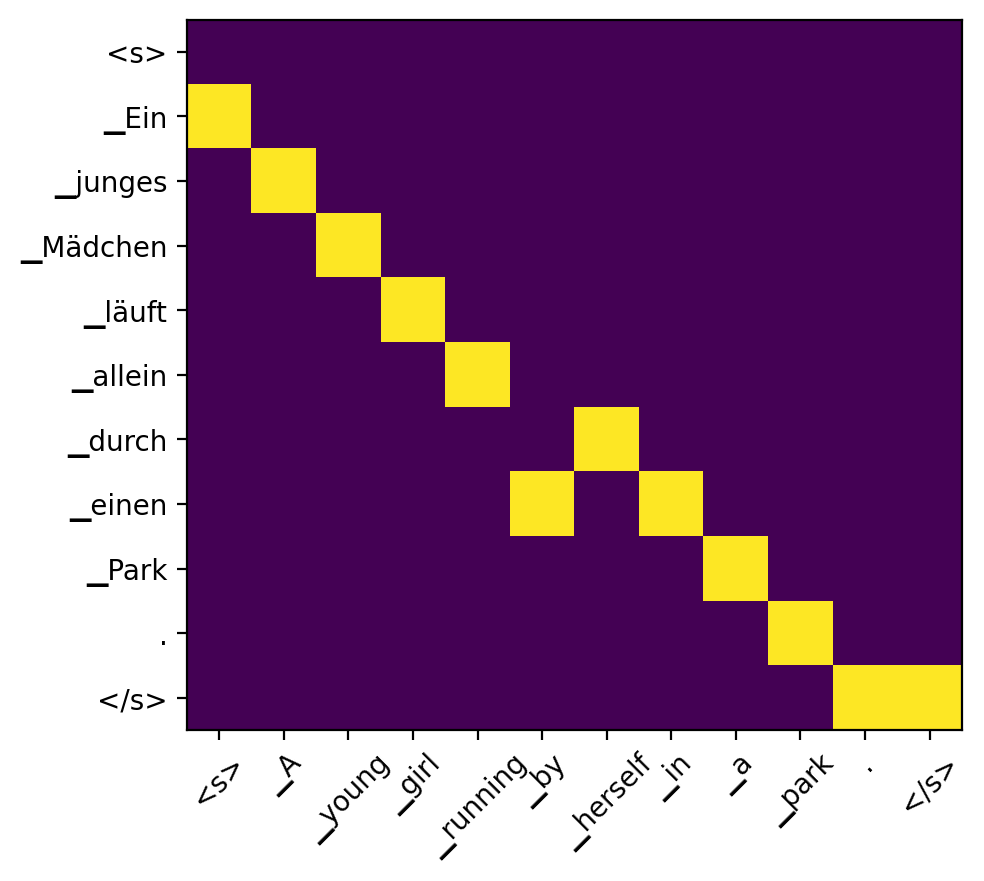

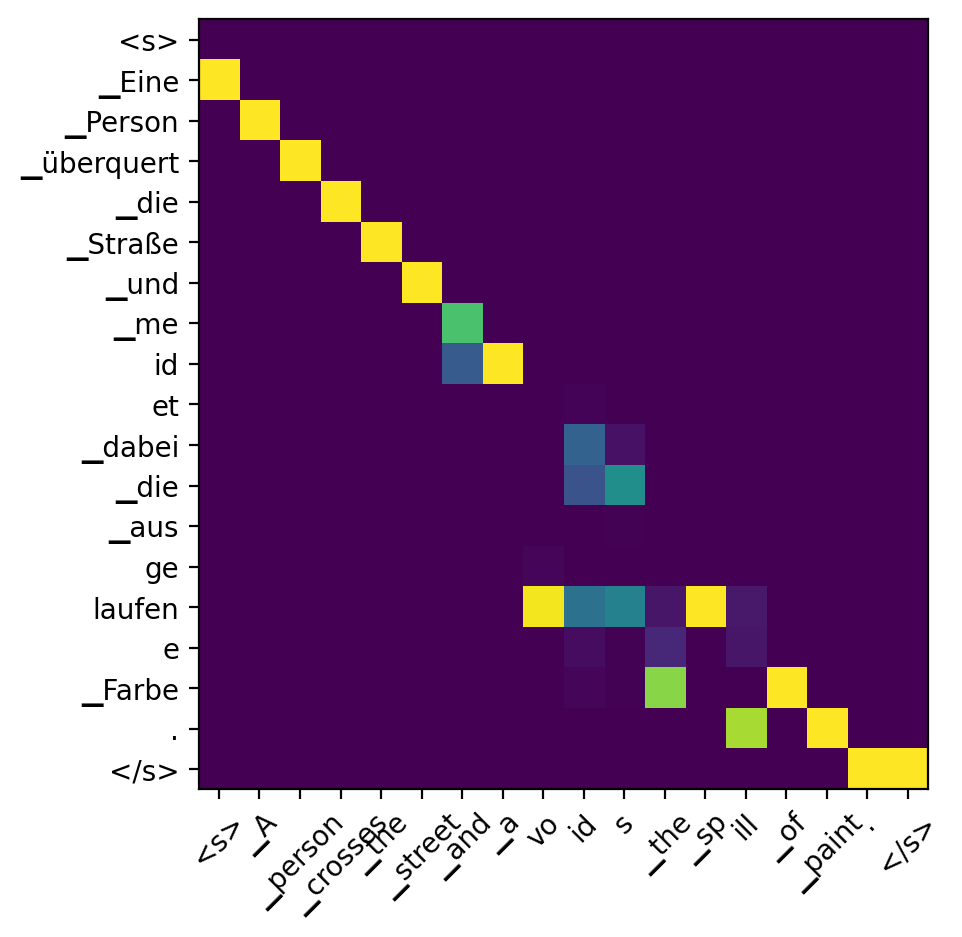

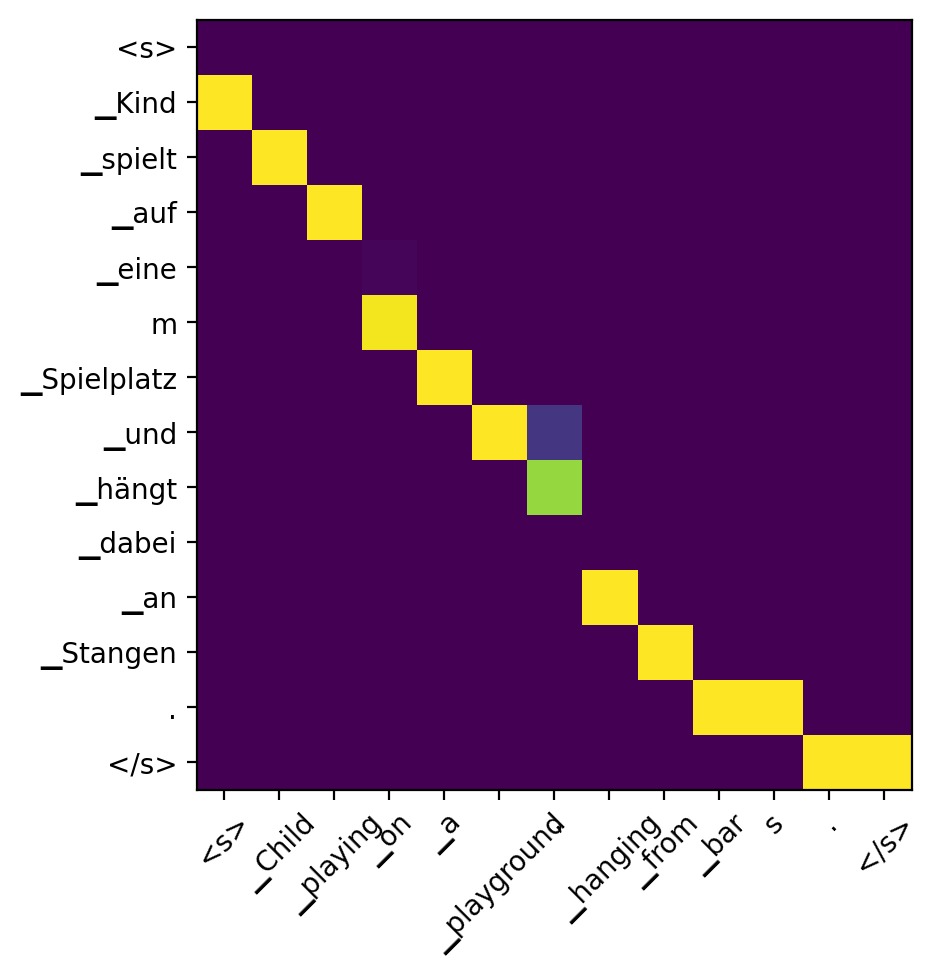

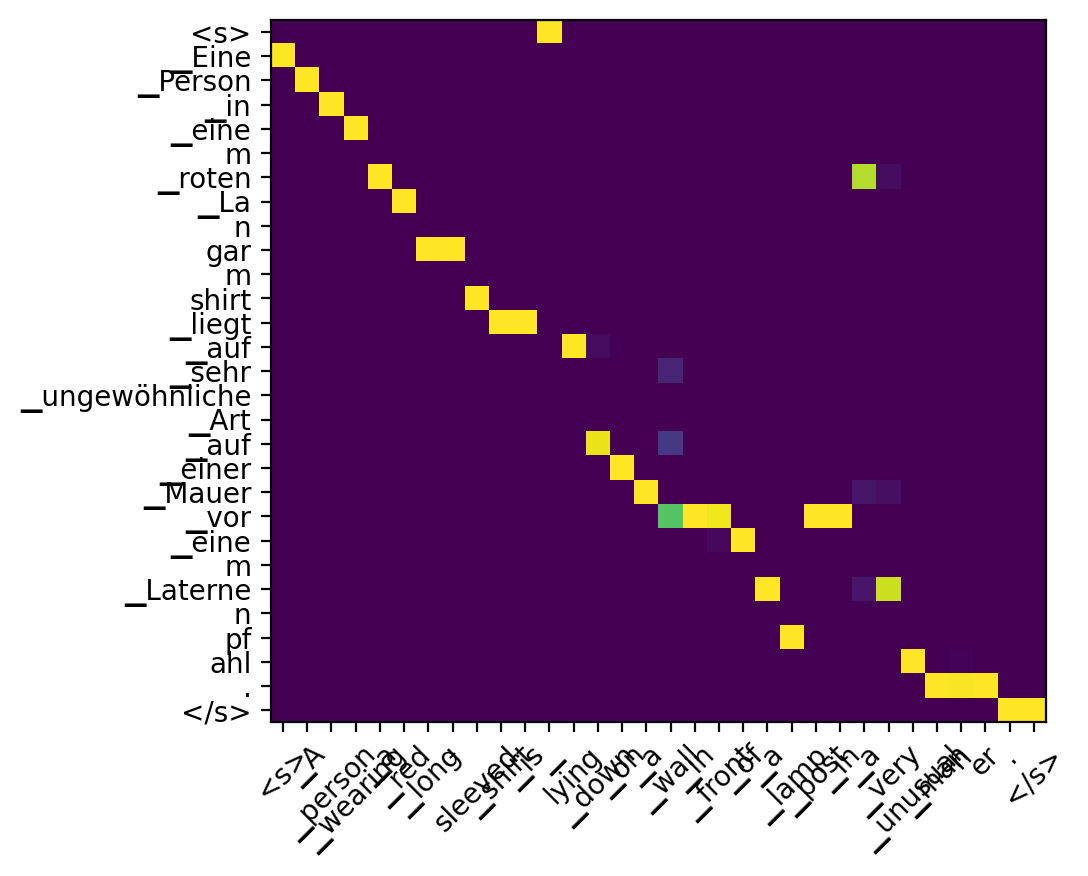

In [182]:
# You may find the following annotated heatmap tutorial helpful:
# https://matplotlib.org/3.1.3/gallery/images_contours_and_fields/image_annotated_heatmap.html.

# YOUR CODE HERE
def test(model, sentences, targets, max_length=50):
  batch_input = make_batch(sentences).cuda()
  decoder_input = make_batch(targets).cuda()

  batch_size = batch_input.shape[-1]
  # decoder_input = torch.tensor([[bos_id] for i in range(batch_size)]).long()
  # decoder_input = decoder_input.transpose(0,1).cuda()

  encoder_output, encoder_mask, encoder_hidden = model.encode(batch_input)
  logits, decoder_hidden, attention_weights = model.decode(decoder_input, encoder_hidden, encoder_output, encoder_mask)

#   is_eos = [0 for i in range(batch_size)]
#   while decoder_input.shape[0] < max_length:
#     logits, decoder_hidden, attention_weights = model.decode(decoder_input, encoder_hidden, encoder_output, encoder_mask)
#     logits = logits[-1,:,:]
#     token_ids = torch.argmax(F.softmax(logits,-1),-1)

#     # flag which sentence has end
#     for index, token_id in enumerate(token_ids):
#       if token_id == eos_id:
#         is_eos[index] = 1
#     # if ends add 1e9 to the logit of pad
#     for index, flag in enumerate(is_eos):
#       if flag==1:
#         logits[index,pad_id]+=1e9

#     token_ids = torch.argmax(F.softmax(logits,-1),-1).unsqueeze(0)
#     decoder_input = torch.cat([decoder_input,token_ids],dim=0)
  
  lengths = ((decoder_input != pad_id).sum(0))
  decoder_input = decoder_input.transpose(0,1).tolist()

  return batch_input,decoder_input,attention_weights,lengths

test_data = [i.src for i in validation_data[30:34]]
test_targets = [i.trg for i in validation_data[30:34]]
batch_input,decoder_input,attention_weights,lengths = test(attention_model,test_data,test_targets)
input_lengths = ((batch_input != pad_id).sum(0))
batch_input = batch_input.transpose(1,0).tolist()
translated = decoder_input

for index in range(4):
    plt.figure(figsize=(5,5),dpi=200)
    plt.yticks(range(len(batch_input[index][:input_lengths[index]])), [vocab.id_to_piece(i) for i in batch_input[index][:input_lengths[index]]])
    plt.xticks(range(len(decoder_input[index][:lengths[index]])),[vocab.id_to_piece(i) for i in decoder_input[index][:lengths[index]]],rotation=45)
    plt.imshow(attention_weights.detach().cpu().numpy()[:lengths[index],index,:input_lengths[index]].transpose(1,0))
    plt.savefig(f'{index}.png')
    plt.show()
    

 - Most of the time, attention is one to one.
 - But in some of the words which its format should consider number, time, or gender, the attentions are usually many to one.
     - Verb tokens have strong relation to time sence, like serv**ing**, ic**ed**, and jump**ing**.
     - Noun tokens have strong relation to number, like drink**s** and **a wall**.
 

## Submission

Turn in the following files on Gradescope:
* hw2a.ipynb (IBM alignment notebook)
* example_alignments.pkl (generated from part 2a)
* multi20k_alignments.pkl (generated from part 2a)
* hw2b.ipynb (this notebook)
* predictions.json (the predictions file generated by running the cell below)
* report.pdf

Be sure to check the output of the autograder after it runs.  It should confirm that no files are missing and that the output files have the correct format.

The code below will generate the required predictions file.  **Note** that it is designed to create the file even if some required elements are missing so that you can submit for partial credit.  If you want full credit, you should check the output to make sure there are no warnings indicating missing portions.

In [73]:
# Run this cell to generate the predictions.json file required for submission.

def get_raw_predictions(model, dataset, method, batch_size=64):
  assert method in {"greedy", "beam"}
  source_sentences = [example.src for example in dataset]
  target_sentences = [example.trg for example in dataset]
  model.eval()
  predictions = []
  with torch.no_grad():
    for start_index in range(0, len(source_sentences), batch_size):
      if method == "greedy":
        prediction_batch = predict_greedy(
            model, source_sentences[start_index:start_index + batch_size])
      else:
        prediction_batch = predict_beam(
            model, source_sentences[start_index:start_index + batch_size])
      predictions.extend(prediction_batch)
  return predictions

def generate_predictions_file_for_submission(filepath):
  models = {"baseline": baseline_model, "attention": attention_model}
  datasets = {"validation": validation_data, "test": test_data}
  methods = ["greedy", "beam"]
  predictions = {}
  for model_name, model in models.items():
    for dataset_name, dataset in datasets.items():
      for method in methods:
        print(
            "Getting predictions for {} model on {} set using {} "
            "search...".format(model_name, dataset_name, method))
        if model_name not in predictions:
          predictions[model_name] = {}
        if dataset_name not in predictions[model_name]:
          predictions[model_name][dataset_name] = {}
        try:
          predictions[model_name][dataset_name][method] = get_raw_predictions(
              model, dataset, method)
        except:
          print("!!! WARNING: An exception was raised, setting predictions to None !!!")
          predictions[model_name][dataset_name][method] = None
  print("Writing predictions to {}...".format(filepath))
  with open(filepath, "w") as outfile:
    json.dump(predictions, outfile, indent=2)
  print("Finished writing predictions to {}.".format(filepath))

generate_predictions_file_for_submission("predictions.json")

Getting predictions for baseline model on validation set using greedy search...
Getting predictions for baseline model on validation set using beam search...
Getting predictions for baseline model on test set using greedy search...
Getting predictions for baseline model on test set using beam search...
Getting predictions for attention model on validation set using greedy search...
Getting predictions for attention model on validation set using beam search...
Getting predictions for attention model on test set using greedy search...
Getting predictions for attention model on test set using beam search...
Writing predictions to predictions.json...
Finished writing predictions to predictions.json.
